# Dataset: 
https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification

In [228]:
import os

def display_contents(path, indent=0):
    for root, dirs, files in os.walk(path):
        current_indent = ' ' * indent
        print(f"{current_indent}{root}")
        
        for file in files[:3]:
            print(f"{current_indent}  File: {file}")
        if len(files) > 3:
            print(f"{current_indent}  ... [ total : {len(files)}]")
        
        for directory in dirs:
            display_contents(os.path.join(root, directory), indent + 2)

def n_images(path):
    counter = 0
    for root, dirs, files in os.walk(path):
        for file in files[:3]:
            counter+=1  
        for directory in dirs:
            counter+=n_images(os.path.join(root, directory))
    return counter

dataset_path = "..\dataset"  # put the path to the dataset
# display_contents(dataset_path) # in case you want to see what the folder looks like
print("N of files (images):",n_images(dataset_path))


N of files (images): 1382


In [229]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import random

In [230]:
input_base_path = dataset_path # path for the dataset
training_folder = 'traffic_Data/DATA'
testing_folder = 'traffic_Data/TEST'
classes = pd.read_csv(os.path.join(input_base_path,'labels.csv'))
print("Total number of classes: ", len(classes))

Total number of classes:  58


In [231]:
from PIL import Image, ImageEnhance
import os

def augment_image(original_image: Image.Image):
    augmented = [original_image]
    for i in range(1, 5):
        augmented_image = original_image.copy()
        if i == 1:
            augmented_image = augmented_image.convert('RGB').quantize(colors=32)
        elif i == 2:
            enhancer = ImageEnhance.Brightness(augmented_image)
            augmented_image = enhancer.enhance(0.7)
        elif i == 3:
            augmented_image = augmented_image.rotate(25)
        elif i == 4:
            augmented_image = augmented_image.rotate(-25)
        augmented.append(augmented_image)
    return augmented

In [232]:
from tqdm import tqdm


traffic_data = []
training_data = []
labels = []
def fetch_images(traffic_data: list, labels: list, augment: bool = False) -> tuple[list, list]:
    for class_value in tqdm(os.listdir(os.path.join(input_base_path, training_folder))):
        class_path = os.path.join(input_base_path, training_folder, class_value)
        labels.append(class_value)
        for trafficSignal in os.listdir(class_path):
            img = Image.open(os.path.join(class_path,trafficSignal))
            if augment:
                for img in augment_image(img):
                    img = img.resize((90,90))
                    img = np.array(img)
                    traffic_data.append((img,[int(class_value)]))
            else:
                img = img.resize((90,90))
                img = np.array(img)
                traffic_data.append((img,[int(class_value)]))
    labels = np.array(labels)
    return traffic_data, labels

In [233]:
traffic_data, labels = fetch_images(traffic_data, labels)
traffic_data_features, traffic_data_labels = zip(*traffic_data)
training_data_features, validation_data_features, training_data_labels, validation_data_labels = train_test_split(traffic_data_features, traffic_data_labels, test_size=0.33, random_state=42)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)
print(training_data_features.shape)
print(training_data_labels.shape)

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:13<00:00,  4.38it/s]


(2793, 90, 90, 3)
(2793, 1)


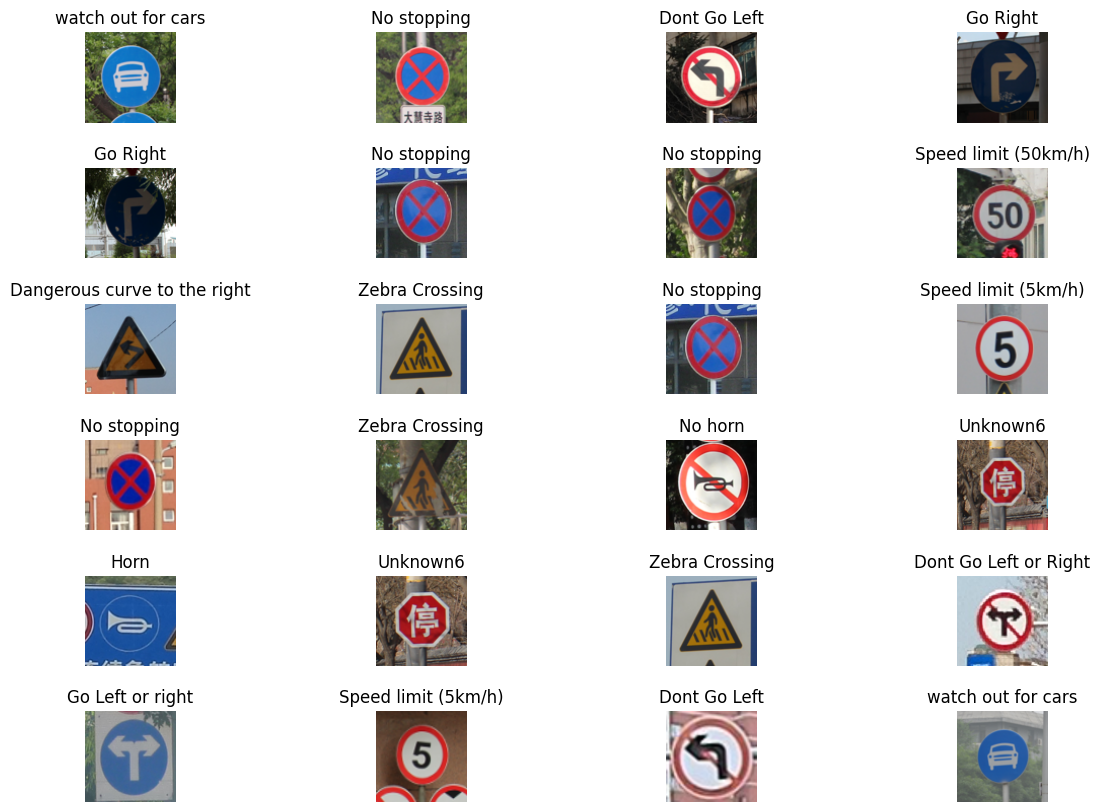

In [234]:
def img_displayer(data_features: list, data_labels_act: list, data_labels_pred: list = None):
    rows, cols = 6, 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    plt.subplots_adjust(wspace = 0, hspace = 0.5) 
    if data_labels_pred is not None:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label_act = classes['Name'][data_labels_act[i*random_val][0]]
                display_label_pred = classes['Name'][data_labels_pred[i*random_val]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title((display_label_act, display_label_pred))
                axes[row, col].axis('off')
    else:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label = classes['Name'][data_labels_act[i*random_val][0]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title(display_label)
                axes[row, col].axis('off')
img_displayer(training_data_features, training_data_labels)

In [235]:
def convolution_model() -> Sequential:
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), padding="same", input_shape=(90, 90, 3), activation='relu'))
    print(cnn_model(training_data_features).shape)
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(128,(5,5), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(256,(7,7), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(232, activation='relu'))
    cnn_model.add(Dense(116, activation='relu'))
    cnn_model.add(Dense(58, activation='softmax'))
    return cnn_model

In [236]:
epochs = 12
batch_size = 14
cnn_model = convolution_model()
cnn_model.summary()

: 

In [ ]:
print(training_data_features.shape, training_data_labels.shape)
print(training_data_labels)

(2793, 90, 90) (2793, 1)
[[28]
 [54]
 [11]
 ...
 [ 5]
 [55]
 [17]]


In [ ]:
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
traffic_sign_network = cnn_model.fit(training_data_features, training_data_labels, batch_size=batch_size, epochs=epochs, validation_data=(validation_data_features, validation_data_labels))

Epoch 1/24


c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


200/200 [==============================] - 21s 65ms/step - loss: 3.1194 - accuracy: 0.3140 - val_loss: 1.5965 - val_accuracy: 0.6492
Epoch 2/24
200/200 [==============================] - 11s 57ms/step - loss: 0.9656 - accuracy: 0.7608 - val_loss: 0.6789 - val_accuracy: 0.8337
Epoch 3/24
200/200 [==============================] - 11s 57ms/step - loss: 0.3668 - accuracy: 0.8955 - val_loss: 0.4654 - val_accuracy: 0.8853
Epoch 4/24
200/200 [==============================] - 12s 58ms/step - loss: 0.1942 - accuracy: 0.9481 - val_loss: 0.3771 - val_accuracy: 0.9208
Epoch 5/24
200/200 [==============================] - 15s 74ms/step - loss: 0.1542 - accuracy: 0.9549 - val_loss: 0.3414 - val_accuracy: 0.9150
Epoch 6/24
200/200 [==============================] - 15s 74ms/step - loss: 0.0774 - accuracy: 0.9757 - val_loss: 0.3621 - val_accuracy: 0.9542
Epoch 7/24
200/200 [==============================] - 15s 74ms/step - loss: 0.1202 - accuracy: 0.9635 - val_loss: 0.3252 - val_accuracy: 0.9441
Epo

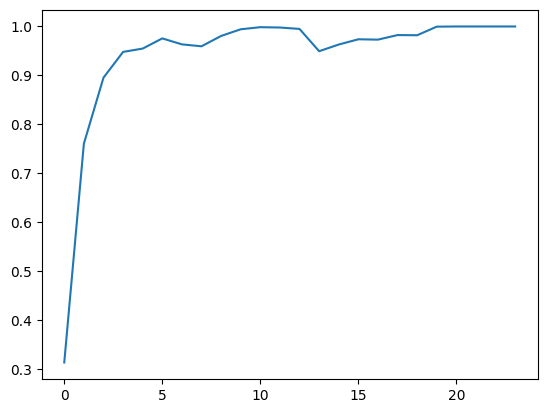

In [ ]:
plt.plot(traffic_sign_network.history['accuracy'], label='accuracy')

In [ ]:
# Evaluating the model on test data
testing_data = []
for test_image_file in os.listdir(os.path.join(input_base_path, testing_folder)):
    testImage = Image.open(os.path.join(input_base_path, testing_folder, test_image_file))
    testImage = testImage.convert("L")
    testImage = testImage.resize((90,90))
    testImage = np.array(testImage)
    testing_data.append((testImage, [int(test_image_file[1:3])]))
testing_data_features, testing_data_labels = zip(*testing_data)
testing_data_features = np.array(testing_data_features)
testing_data_labels = np.array(testing_data_labels)

In [ ]:
# Evaluate the test data
predictions = cnn_model.predict(testing_data_features)
predicted_labels = np.argmax(predictions, axis=1)

63/63 [==============================] - 3s 43ms/step


8     Dont Go straight or left
13               Dont Go Right
0          Speed limit (5km/h)
0          Speed limit (5km/h)
0          Speed limit (5km/h)
                ...           
56                    Unknown7
57                    Unknown8
57                    Unknown8
57                    Unknown8
57                    Unknown8
Name: Name, Length: 1994, dtype: object
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
             ...         
56               Unknown7
57               Unknown8
57               Unknown8
57               Unknown8
57               Unknown8
Name: Name, Length: 1994, dtype: object


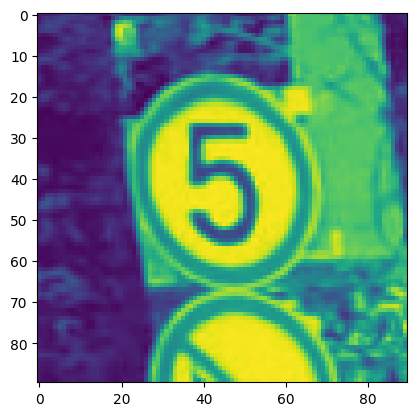

In [ ]:
# Visualize Result Data and Actual Data
print(classes['Name'][predicted_labels])
print(classes['Name'][testing_data_labels[:,0]])
plt.imshow(testing_data_features[1])

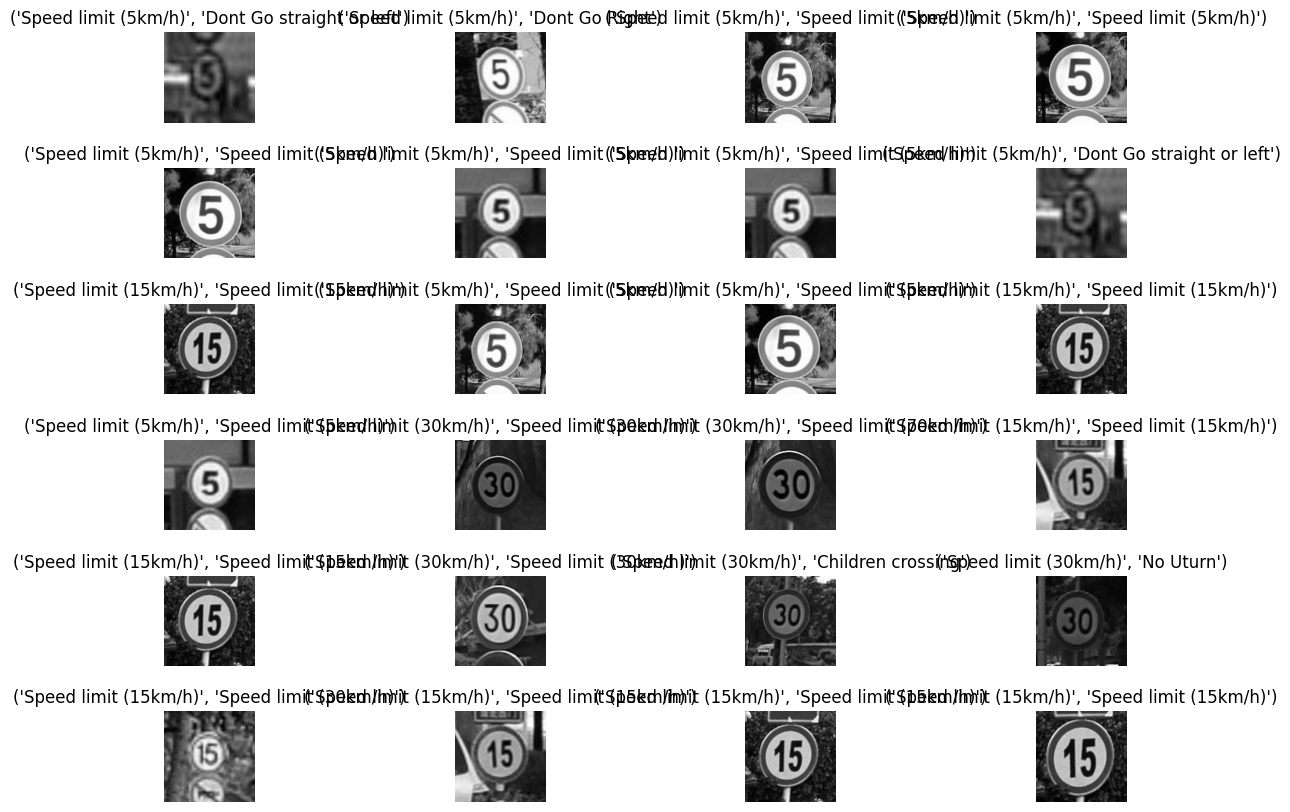

In [ ]:
img_displayer(testing_data_features, testing_data_labels, predicted_labels)
# (Actual Label, Predicted Label)

In [ ]:
test_loss, test_acc = cnn_model.evaluate(testing_data_features, testing_data_labels, verbose=2)
print(test_acc)

63/63 - 2s - loss: 5.3277 - accuracy: 0.5587 - 2s/epoch - 37ms/step
0.55867600440979


# Let Analyse the challenges in this dataset

1. The data available is not equaly distributed among the classes. Thus leading to the biased models which is one of the most common problem in the world of machine learning.
2. There are some images without proper labeling but luckily there aren't images of mutiple types under single lable.
